In [244]:
%load_ext autoreload

%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [245]:
from plot_images import plot_images
from tools import load_json, read_yaml_config, export_annos, final_join, filter_by_csv, assign_viewpoints
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import warnings
warnings.filterwarnings("ignore")

### Load data

In [246]:
config_file_path = '/home/kate/code/wbia-plugin-miew-id/wbia_miew_id/helpers/split/configs/config_kate.yaml'
species = 'leopard'
config = read_yaml_config(config_file_path, species)
print(config)

train_anno_path = config["train_anno_path"]
val_anno_path = config["val_anno_path"]
test_anno_path = config["test_anno_path"]


train_images_dir = config["train_images_dir"]

excluded_viewpoints = config['excluded_viewpoints']

train_data = load_json(train_anno_path)
val_data = load_json(val_anno_path)
test_data = load_json(test_anno_path)


dfa_train = pd.DataFrame(train_data['annotations'])
dfi_train = pd.DataFrame(train_data['images'])

dfa_val = pd.DataFrame(val_data['annotations'])
dfi_val = pd.DataFrame(val_data['images'])

dfa_test = pd.DataFrame(test_data['annotations'])
dfi_test = pd.DataFrame(test_data['images'])


dfa = pd.concat([dfa_train, dfa_val, dfa_test])
dfi = pd.concat([dfi_train, dfi_val, dfi_test])


df = dfa.merge(dfi, left_on='image_id', right_on='id')
df = df.reset_index(drop=True)


df['path'] = df['file_name'].apply(lambda x: os.path.join(train_images_dir, x))

assert df['path'].apply(os.path.exists).all()

{'data_dir': '/media/kate/Elements1/ISYNC-LUT/leopard/coco', 'export_dir': '/media/kate/Elements1/ISYNC-LUT/leopard/coco/export_annotations_test', 'train_images_dir': '/media/kate/Elements1/ISYNC-LUT/leopard/coco/images/test2023', 'train_anno_path': '/media/kate/Elements1/ISYNC-LUT/leopard/coco/annotations/instances_train2023.json', 'val_anno_path': '/media/kate/Elements1/ISYNC-LUT/leopard/coco/annotations/instances_val2023.json', 'test_anno_path': '/media/kate/Elements1/ISYNC-LUT/leopard/coco/annotations/instances_test2023.json', 'excluded_viewpoints': ['front', 'back', 'up', 'down'], 'csv_folder': '/media/kate/Elements1/ISYNC-LUT/leopard/coco/csvs'}


In [247]:
# Need to create 'species' key in the df. Automatically build this from coco file categories

cat_list = test_data['categories']
cat_map = {item['id']: item['name'] for item in cat_list}
df['species'] = df['category_id'].map(cat_map)

cat_map

{0: 'leopard'}

14289


<AxesSubplot:>

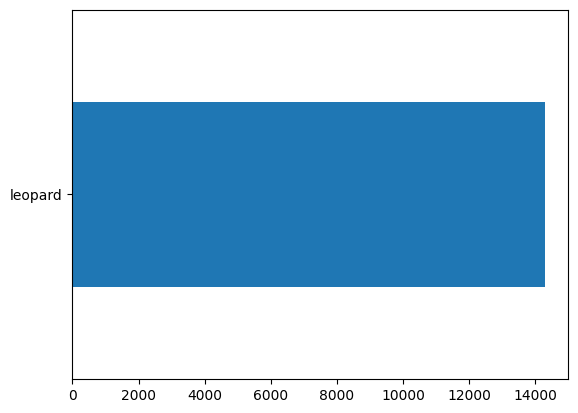

In [248]:
print(len(df))
df['species'].value_counts().plot(kind='barh')

In [249]:
# Filter by csv. Support multiple files

csv_folder = config['csv_folder']
if os.path.exists(csv_folder):
    names=['annotation_uuid', 'species', 'viewpoint', 'name_uuid', 'name', 'date']
    # names = ['annotation_uuid', 'viewpoint']
    # merge_cols = ['annotation_uuid', 'viewpoint']

    # df = filter_by_csv(df, csv_folder, names=names, merge_cols=merge_cols)
    df = filter_by_csv(df, csv_folder, names=names)

df = assign_viewpoints(df, excluded_viewpoints)

7012


<AxesSubplot:>

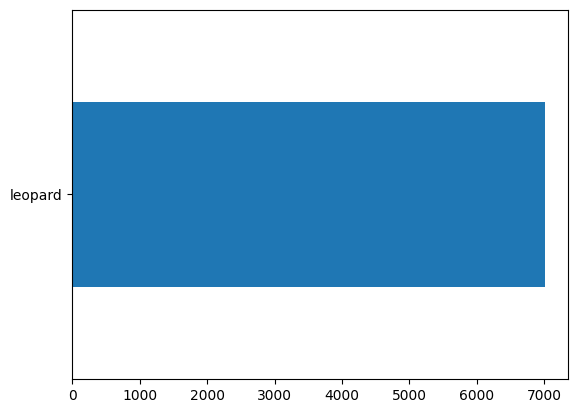

In [250]:
print(len(df))
df['species'].value_counts().plot(kind='barh')

In [251]:
df['name_viewpoint'] = df['name'] + '-' + df['viewpoint']
df['species_viewpoint'] = df['species'] + '-' + df['viewpoint']

In [252]:
# Make sure merging did not create duplicates
assert not df.astype(str).duplicated().any()

### Visualize

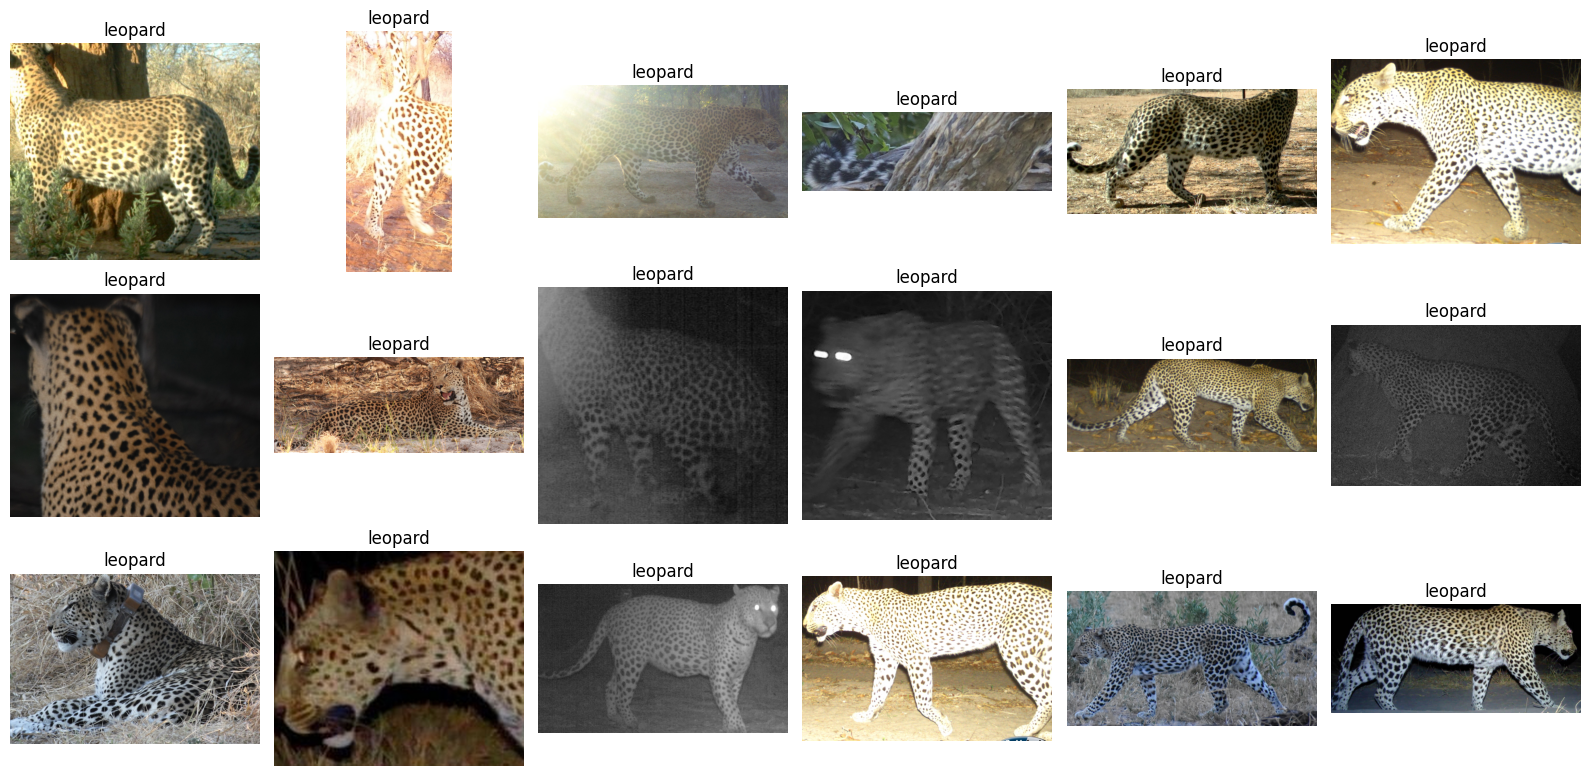

In [253]:
for species in df['species'].unique():
    plot_images(df, species=species, crop_bbox=True)

### Split
- The split 

In [254]:
from split import split_df

In [255]:
df['species'].value_counts()

leopard    7012
Name: species, dtype: int64

In [256]:
len(df['name'].unique())

537

In [257]:
# apply split function
df_tr, df_te, df_val = split_df(df, train_ratio=0.7, unseen_ratio=0.5, is_val=True, stratify_col='name', print_key='name_viewpoint', verbose=True)



Filtering...
Calculating stats for combined subsets
** cross-set stats **

- Counts: 
number of individuals in train:  450
number of annotations in train:  4753

number of individuals in test:  396
number of annotations in test:  1090

train ratio:  0.8134519938387814
number of individuals in val:  389
number of annotations in val:  1092

average number of annotations per individual in train: 10.56
average number of annotations per individual in test: 2.75
average number of annotations per individual in val: 2.81

- New individuals: 
number of new (unseen) individuals in test: 199
ratio of new names to all individuals in test: 0.50

number of new (unseen) individuals in val: 190
ratio of new names to all individuals in val: 0.49
- Individuals in sets: 
number of overlapping individuals in train & test: 197
ratio of overlapping names to total individuals in train: 0.44
ratio of overlapping names to total individuals in test: 0.50
Number of annotations in train for overlapping individual

Train: 
         species  name
leopard      917   240

Test: 
         species  name
leopard      440   220

Val: 
         species  name
leopard      438   219
** cross-set stats **

- Counts: 
number of individuals in train:  430
number of annotations in train:  917

number of individuals in test:  328
number of annotations in test:  440

train ratio:  0.6757553426676493
number of individuals in val:  338
number of annotations in val:  438

average number of annotations per individual in train: 2.13
average number of annotations per individual in test: 1.34
average number of annotations per individual in val: 1.30

- New individuals: 
number of new (unseen) individuals in test: 178
ratio of new names to all individuals in test: 0.54

number of new (unseen) individuals in val: 177
ratio of new names to all individuals in val: 0.52
- Individuals in sets: 
number of overlapping individuals in train & test: 150
ratio of overlapping names to total individuals in train: 0.35
ratio of overl

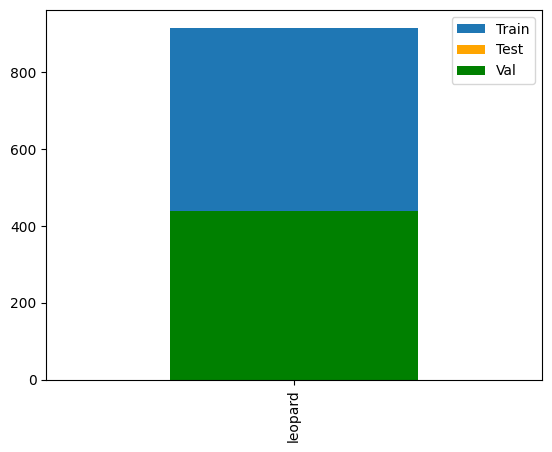

In [258]:
from split import apply_filters, plot_distribution, intersect_stats

df_tr_filtered = apply_filters(df_tr, 'name', max_df=4, min_df=2)
df_te_filtered = apply_filters(df_te, 'name', max_df=2, min_df=2)
df_val_filtered = apply_filters(df_val, 'name', max_df=2, min_df=2)

plot_distribution(df_tr_filtered, df_te_filtered, df_val_filtered)
intersect_stats(df_tr_filtered, df_te_filtered, df_val_filtered, key='name_viewpoint')

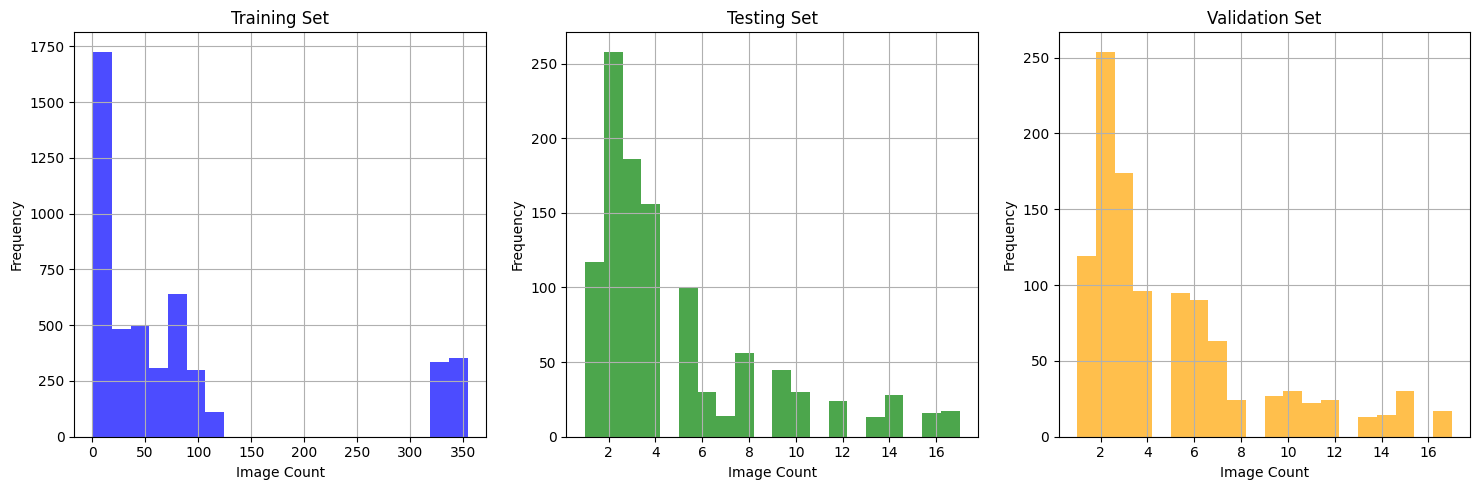

In [259]:
# Add 'image_count" col

from tools import add_image_count

df_tr = add_image_count(df_tr, 'name_viewpoint')
df_te = add_image_count(df_te, 'name_viewpoint')
df_val = add_image_count(df_val, 'name_viewpoint')


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms for each DataFrame in a separate subplot
df_tr['image_count'].hist(ax=axes[0], bins=20, color='blue', alpha=0.7)
axes[0].set_title('Training Set')
axes[0].set_xlabel('Image Count')
axes[0].set_ylabel('Frequency')

df_te['image_count'].hist(ax=axes[1], bins=20, color='green', alpha=0.7)
axes[1].set_title('Testing Set')
axes[1].set_xlabel('Image Count')
axes[1].set_ylabel('Frequency')

df_val['image_count'].hist(ax=axes[2], bins=20, color='orange', alpha=0.7)
axes[2].set_title('Validation Set')
axes[2].set_xlabel('Image Count')
axes[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

### Generate files to be exported






In [260]:
dfa_tr, dfi_tr = final_join(df_tr, dfa, dfi, df)
dfa_te, dfi_te = final_join(df_te, dfa, dfi, df)
dfa_val, dfi_val = final_join(df_val, dfa, dfi, df)

### Final data distribution sanity checks

<AxesSubplot:>

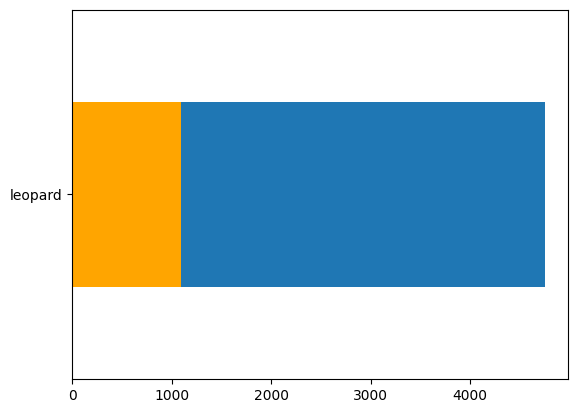

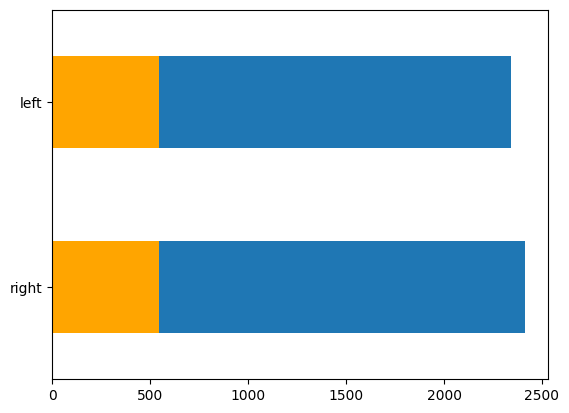

In [261]:
fig, ax = plt.subplots()
# ax2 = ax.twiny()
dfa_tr['species'].value_counts().plot(kind='barh', ax=ax)
dfa_te['species'].value_counts().plot(kind='barh', ax=ax, color='orange')

fig, ax = plt.subplots()
# ax2 = ax.twiny()
dfa_tr['viewpoint'].value_counts().plot(kind='barh', ax=ax)
dfa_te['viewpoint'].value_counts().plot(kind='barh', ax=ax, color='orange')

In [262]:
assert not dfa_tr['uuid'].duplicated().any()

### Export

In [263]:
export_dir = config["export_dir"]
os.makedirs(export_dir, exist_ok=True)


def coco_path(split): return f"instances_{split}2023.json"


train_coco_path = os.path.join(export_dir, coco_path('train'))
val_coco_path = os.path.join(export_dir, coco_path('val'))
test_coco_path = os.path.join(export_dir, coco_path('test'))

export_annos(dfa_tr, dfi_tr, train_coco_path)
export_annos(dfa_val, dfi_val, val_coco_path)
export_annos(dfa_te, dfi_te, test_coco_path)

out_path /media/kate/Elements1/ISYNC-LUT/leopard/coco/export_annotations_test/instances_train2023.json
shapes:  (4753, 19) (4749, 12)
len(images_list) 4749
len(annos_list) 4753
out_path /media/kate/Elements1/ISYNC-LUT/leopard/coco/export_annotations_test/instances_val2023.json
shapes:  (1092, 19) (1092, 12)
len(images_list) 1092
len(annos_list) 1092
out_path /media/kate/Elements1/ISYNC-LUT/leopard/coco/export_annotations_test/instances_test2023.json
shapes:  (1090, 19) (1089, 12)
len(images_list) 1089
len(annos_list) 1090
